In [4]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

In [5]:
# Creation of the train, validation and test dataset
# The split for train, validation and test is 80 - 16 - 4

data_dir = "../data/raw/"

batch_size = 32
img_height = 64
img_width = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("Batches for training:", tf.data.experimental.cardinality(train_ds))

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_batches = tf.data.experimental.cardinality(val_ds)

print("Batches for validation:", val_batches.numpy())
test_ds = val_ds.take((val_batches) // 5) # 4% of entire dataset
val_ds = val_ds.skip((val_batches) // 5) # 16% of entire dataset

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 60992 files belonging to 51 classes.
Using 48794 files for training.
Batches for training: tf.Tensor(1525, shape=(), dtype=int64)
Found 60992 files belonging to 51 classes.
Using 12198 files for validation.
Batches for validation: 382
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Black-grass', 'Blueberry___healthy', 'Charlock', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Fat Hen', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Loose Silky-bent', 'Maize', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'R

In [6]:
# Building our (LeNet) model
output_shape = len(class_names)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(1./255))
model.add(tf.keras.layers.Conv2D(filters = 30, kernel_size = (5,5), padding = "valid", activation = "relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate = 0.2)) 
model.add(tf.keras.layers.Dense(units = 128, activation = "relu"))
model.add(tf.keras.layers.Dense(units = output_shape, activation = "softmax"))


In [7]:
# Compiling the model
model.compile(optimizer='adam',
                   loss="SparseCategoricalCrossentropy",
                   metrics=['accuracy'])

# We can set a high number of max_epochs as we will add a callback for early stopping
max_epochs = 200

# Defining the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, verbose = 1, restore_best_weights = True)
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 3, verbose = 1, cooldown = 5)

# Fitting the model
training_history = model.fit(train_ds, validation_data = val_ds, epochs = max_epochs, callbacks = [early_stopping, lr_plateau])


Epoch 1/200
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 339s 222ms/step - accuracy: 0.4821 - loss: 1.9140 - val_accuracy: 0.7424 - val_loss: 0.8249 - learning_rate: 0.0010
Epoch 2/200
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7622 - loss: 0.7629 - val_accuracy: 0.7827 - val_loss: 0.6990 - learning_rate: 0.0010
Epoch 3/200
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.8219 - loss: 0.5564 - val_accuracy: 0.7814 - val_loss: 0.7178 - learning_rate: 0.0010
Epoch 4/200
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.8490 - loss: 0.4558 - val_accuracy: 0.8334 - val_loss: 0.5288 - learning_rate: 0.0010
Epoch 5/200
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.8708 - loss: 0.3863 - val_accuracy: 0.8545 - val_loss: 0.4588 - learning_rate: 0.0010
Epoch 6/200
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.8862 - loss: 0.3404 - val_accuracy: 0.8593 - val_loss: 0.4609 - learning_rate: 0.0010
Epoch 7/200
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step

In [9]:
# Saving the model
model.save("../models/2.0-bbri-lenet_final.keras")


In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 30)     │         2,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │         4,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 51)             │         6,579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,244,195 (4.75 MB)

 Trainable params: 414,731 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 829,464 (3.16 MB)

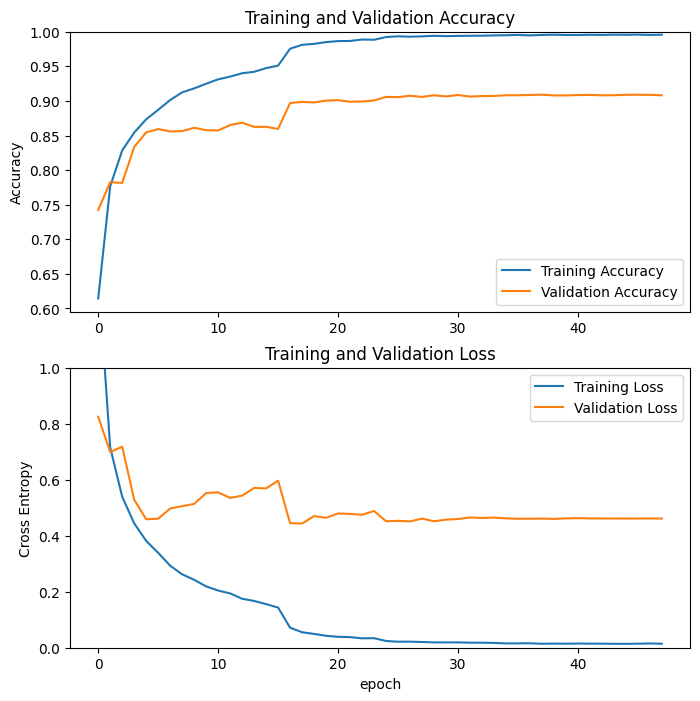

In [11]:
# Assessing the training history
history = training_history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [4]:
# Loading the model - optional
#model = tf.keras.models.load_model("../models/2.0-bbri-lenet_final.keras")

In [12]:
# Creating the true and predicted classes for test_ds
test_classes = np.array([])
predicted_classes = np.array([])

for x, y in test_ds:
  predicted_classes = np.concatenate([predicted_classes, np.argmax(model(x, training=False), axis = -1)]).astype(int)
  test_classes = np.concatenate([test_classes, y.numpy()]).astype(int)


In [13]:
# Print the classification report, for this we "translate" the labels
c_true_class = np.array(class_names)[test_classes]
c_predicted_class = np.array(class_names)[predicted_classes]

print("LeNet")
print(classification_report(c_true_class, c_predicted_class))

LeNet
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.75      0.82      0.78        22
                            Apple___Black_rot       0.97      0.91      0.94        33
                     Apple___Cedar_apple_rust       1.00      0.56      0.71         9
                              Apple___healthy       0.93      0.86      0.89        72
                    Background_without_leaves       0.96      0.96      0.96        50
                                  Black-grass       0.40      0.29      0.33        14
                          Blueberry___healthy       0.95      0.98      0.97        61
                                     Charlock       0.82      1.00      0.90         9
                      Cherry___Powdery_mildew       0.94      0.85      0.89        40
                             Cherry___healthy       1.00      0.97      0.98        30
                                    

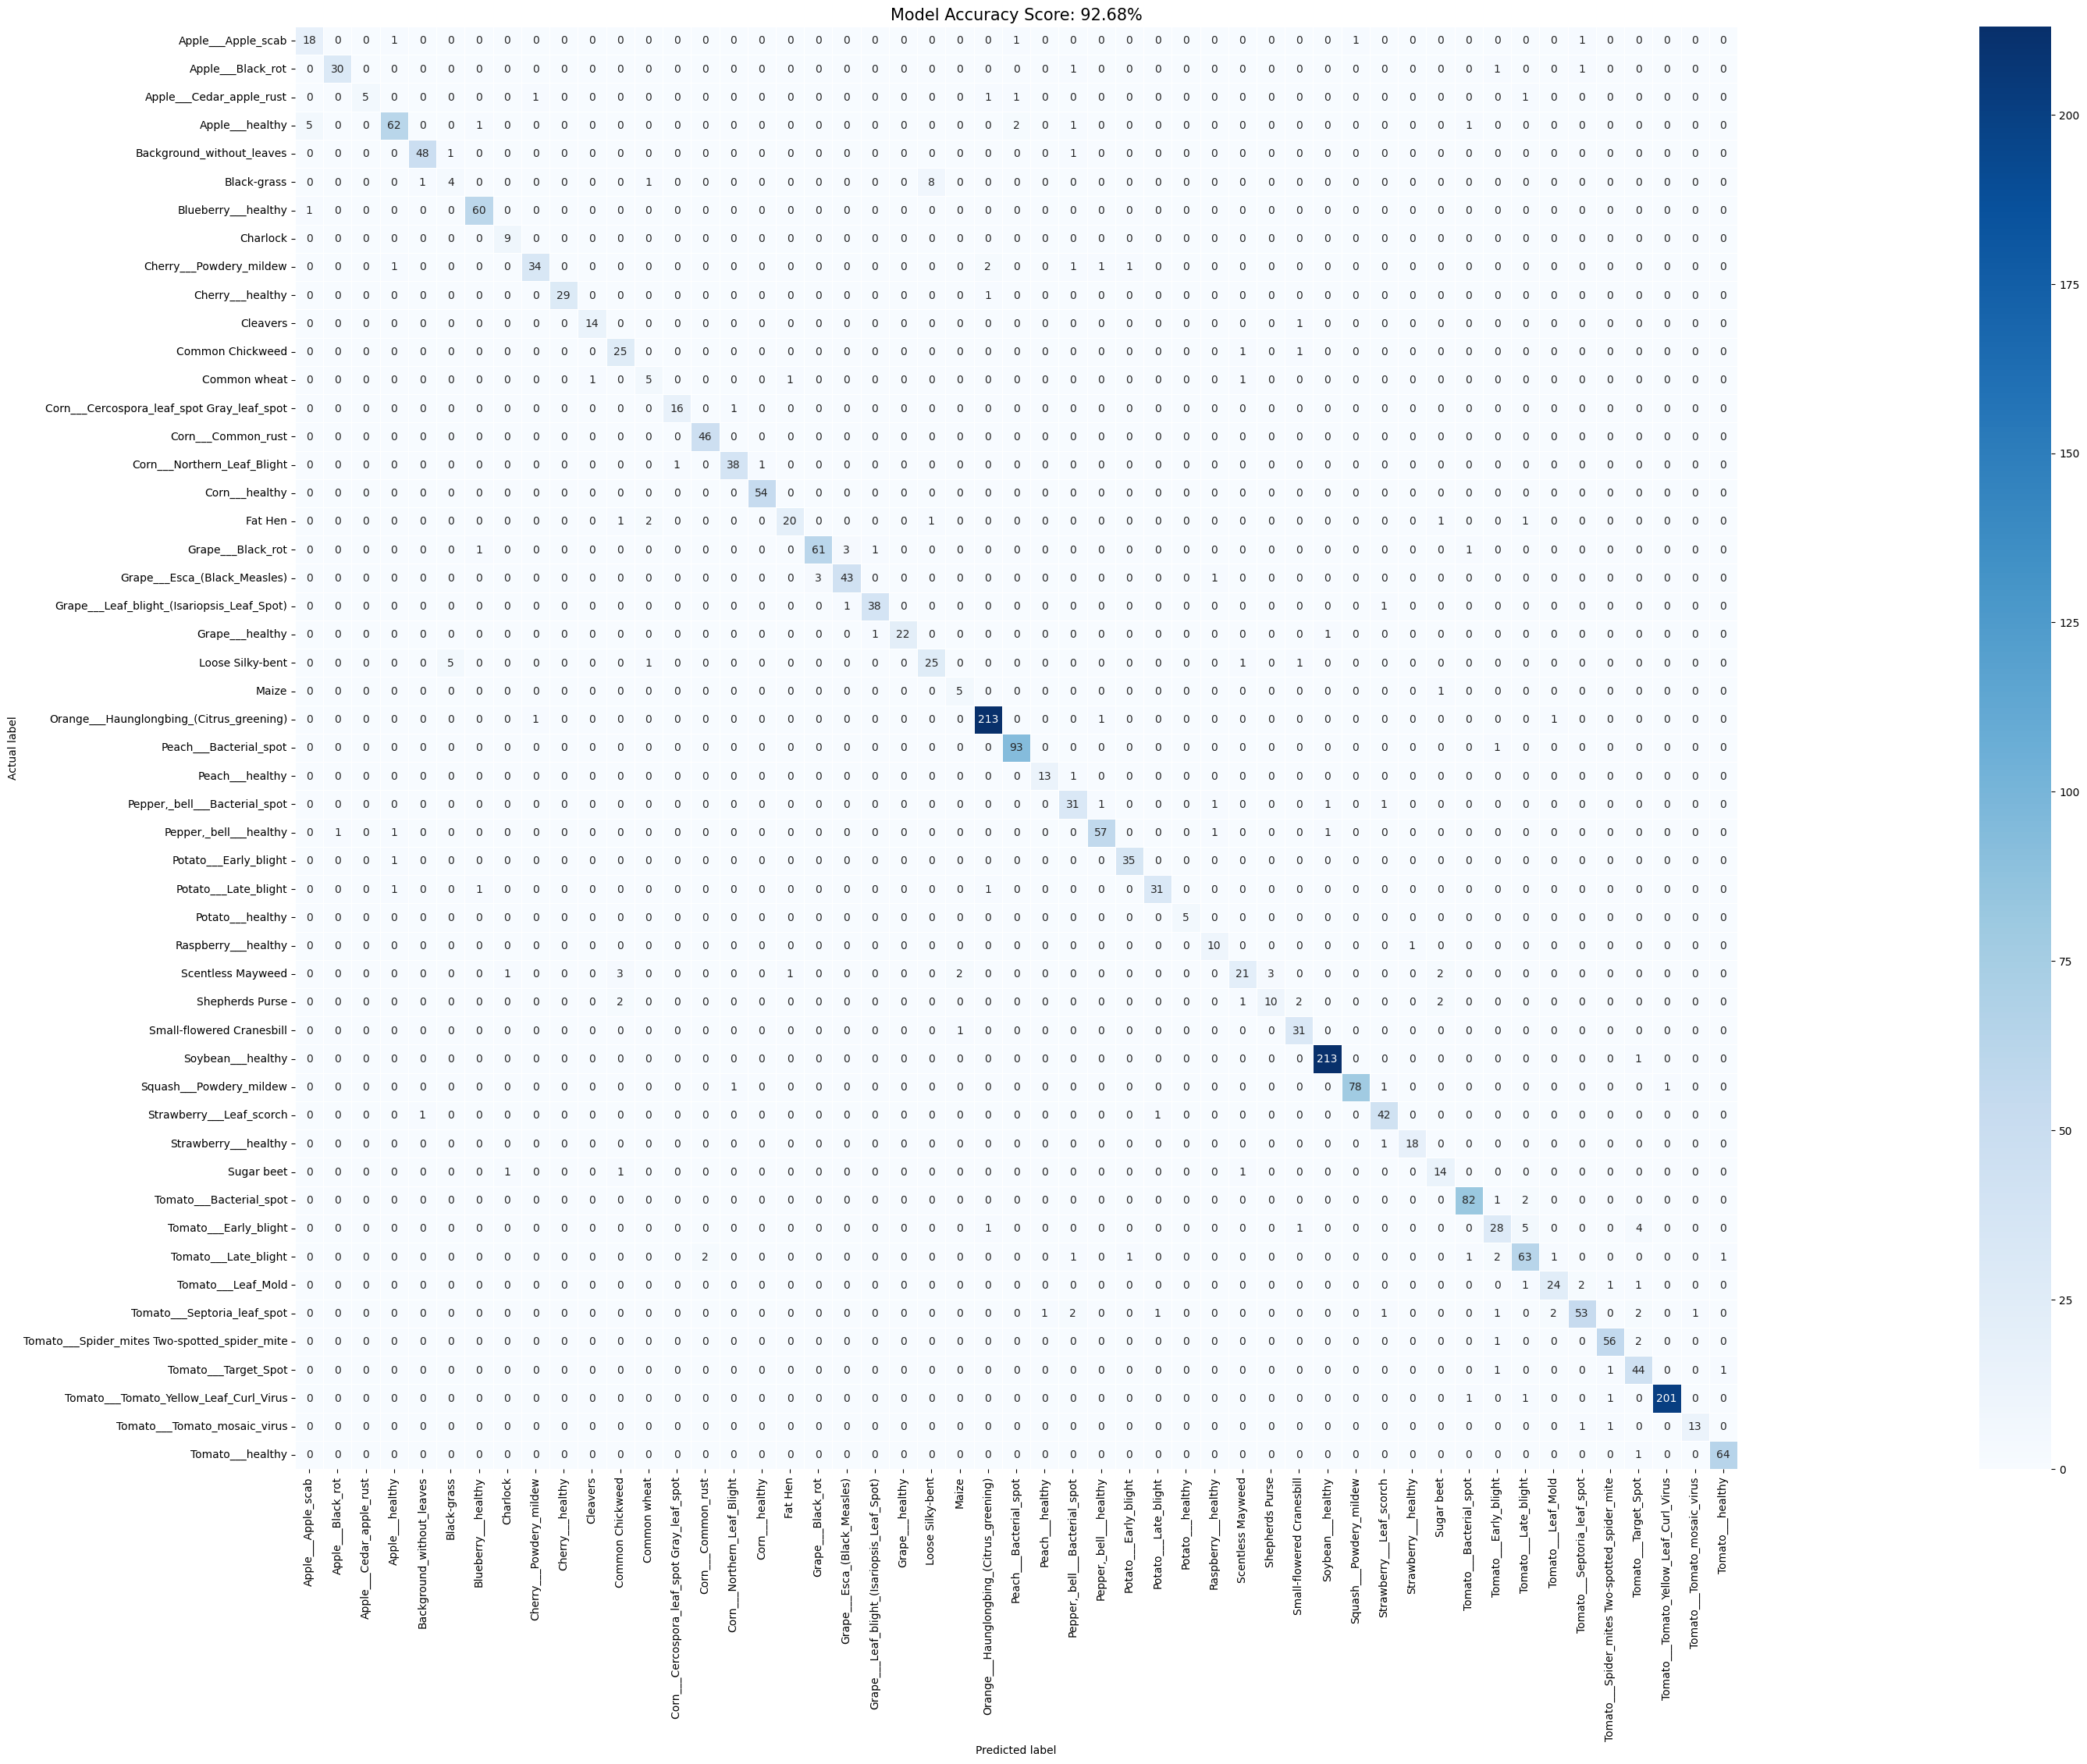

In [14]:
# generate confusion matrix
loss_acc_tuple = model.evaluate(test_ds, verbose=0) #loss_acc_tuple = (loss_acc_tuple[0], loss_acc_tuple[1]) = loss, acc
cm = confusion_matrix(test_classes, predicted_classes)

plt.figure(figsize=(80,24))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {loss_acc_tuple[1]:.2%}'
plt.title(all_sample_title, size = 15)
plt.show()
plt.close()


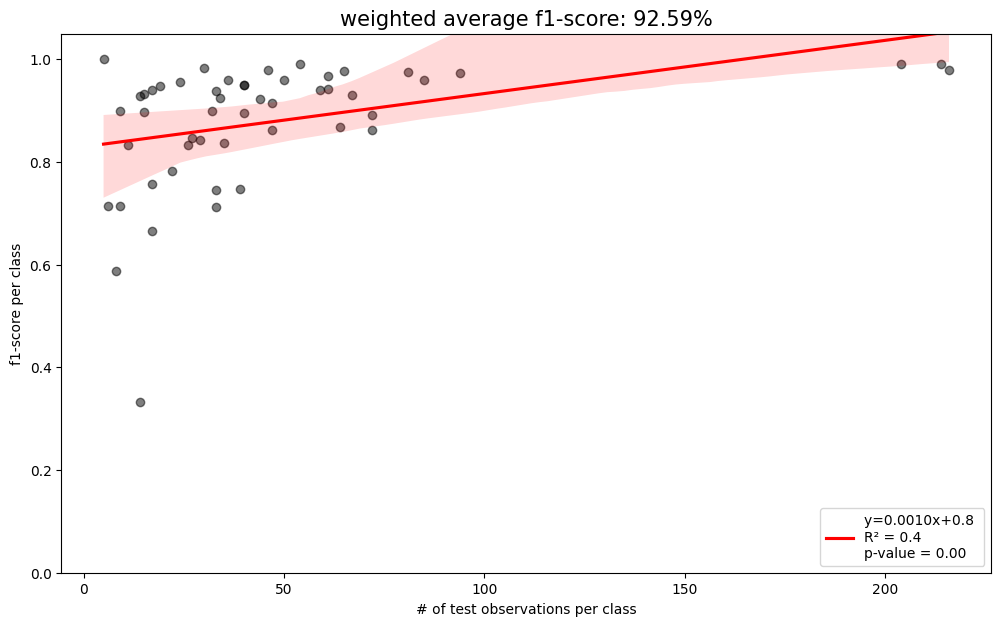

In [15]:
# plot regression model with 99% confidence interval

from sklearn.metrics import precision_recall_fscore_support as score
from scipy.stats import linregress

_,_,fscore,support = score(test_classes,predicted_classes)
_,_,fscore_wavg,_ = score(test_classes,predicted_classes,average='weighted')
slope, intercept, r_value, p_value, _ = linregress(support,fscore)

plt.figure(figsize=(12,7))
ax = sns.regplot(x = support, y = fscore,
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red", 'label':"y={0:.4f}x+{1:.1f} \nR² = {2:.1f} \np-value = {3:.2f}".format(slope,intercept,r_value, p_value)},
            ci = 99)
plt.ylim((0,1.05))
plt.ylabel('f1-score per class')
plt.xlabel('# of test observations per class')
all_sample_title = f'weighted average f1-score: {fscore_wavg:.2%}'
plt.title(all_sample_title, size = 15)
ax.legend(loc="lower right")
#ax.legend()
plt.show();
plt.close();

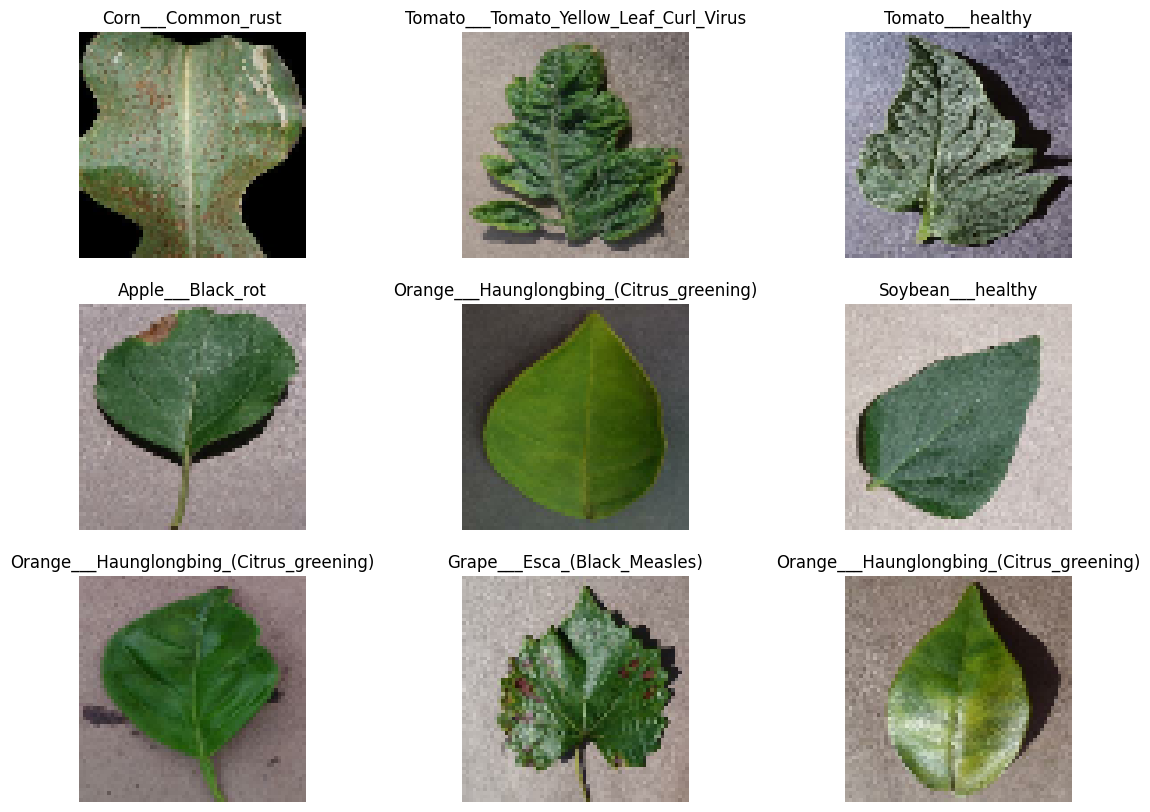

In [17]:
# Plotting some of the images - just for info

plt.figure(figsize=(14, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
